# CS 559 Final Project Class Competition

## Andrew He, Sumanth Reddy Bandi, Thresha Voddiboina

### I pledge my honor that I have abided by the Stevens Honor System.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Helpful Discussion Posts Utilized to Aid Preprocessing

Visualizations, Assumptions about CryoSleep and VIP status based on Expenditure
https://www.kaggle.com/competitions/spaceship-titanic/discussion/406263

Creating new features based on number of passengers in the same group/cabin https://www.kaggle.com/competitions/spaceship-titanic/discussion/399288

General rules for imputing missing values https://www.kaggle.com/competitions/spaceship-titanic/discussion/315987

## Preprocessing (Andrew)

In [2]:
train = pd.read_csv('train_.csv')
valid = pd.read_csv('validation_.csv')
test = pd.read_csv('test_.csv')

In [3]:
# For visualization of entire dataset and to make preprocessing easier, combine the training, validation, and test sets
data = pd.concat([train, valid, test])
data.reset_index(drop = True, inplace = True)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
data.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3856_01,Earth,False,F/726/S,NaN,23.0,False,339.0,754.0,7.0,0.0,0.0,Ward Alvasquez,True
1,6110_01,Earth,False,E/389/P,55 Cancri e,57.0,False,0.0,0.0,0.0,0.0,642.0,Sus Warrishales,True
2,6908_01,Europa,False,C/254/S,TRAPPIST-1e,60.0,False,0.0,960.0,46.0,854.0,17074.0,Sheleon Swinvul,False
3,5628_01,Earth,True,G/900/P,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Ebonya Potthews,False
4,1193_02,Europa,True,B/50/S,55 Cancri e,25.0,False,0.0,0.0,0.0,0.0,0.0,Solam Presstic,True


### General Visualizations

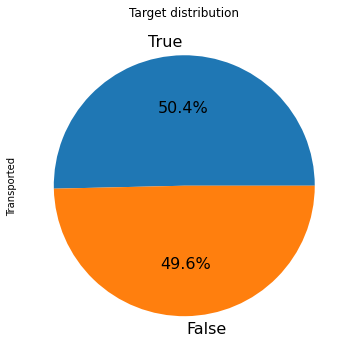

In [6]:
plt.figure(figsize=(6,6))
data['Transported'].value_counts().plot.pie(autopct='%1.1f%%', textprops={'fontsize':16}).set_title("Target distribution")
plt.show()

The distribution of passengers who were transported and those who were not is near equal.

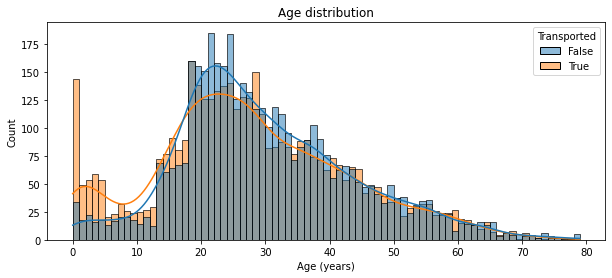

In [7]:
# Histogram of Ages
plt.figure(figsize=(10,4))

sns.histplot(data=data, x='Age', hue='Transported', binwidth=1, kde=True)
plt.title('Age distribution')
plt.xlabel('Age (years)')
plt.show()

Passengers who are children are more likely to be transported, and passengers in their twenties and early thirties are less likely to be transported.

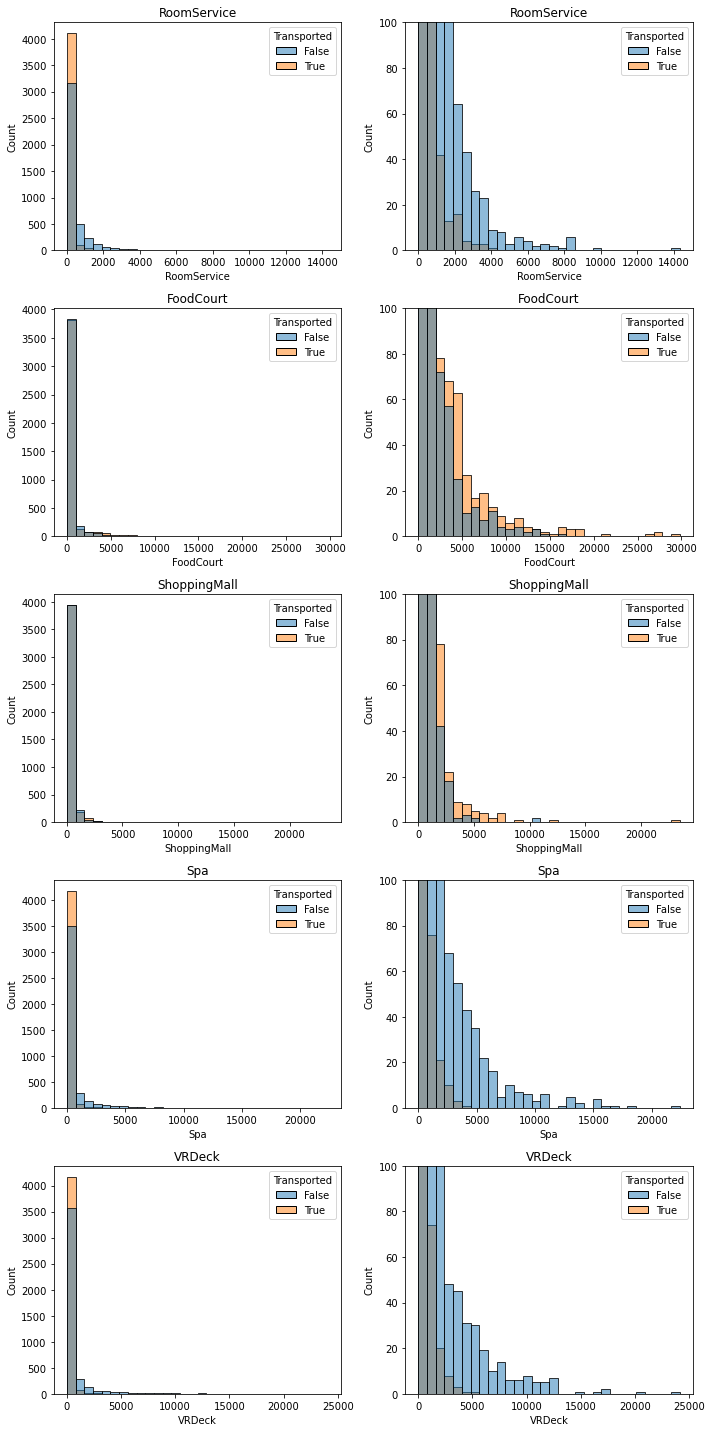

In [8]:
# Expenditure features
exp_feats=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Plot expenditure features
fig=plt.figure(figsize=(10,20))
for i, var_name in enumerate(exp_feats):
    # Left plot
    ax=fig.add_subplot(5,2,2*i+1)
    sns.histplot(data=data, x=var_name, axes=ax, bins=30, hue='Transported')
    ax.set_title(var_name)
    
    # Right plot (truncated)
    ax=fig.add_subplot(5,2,2*i+2)
    sns.histplot(data=data, x=var_name, axes=ax, bins=30, hue='Transported')
    plt.ylim([0,100])
    ax.set_title(var_name)

fig.tight_layout()
plt.show()

We can see that all of the expenditure features have a large number of passengers who spent little to no money, and that passengers who spent less were more likely to be transported. The RoomService, Spa and VRDeck features illustrate this far better than the FoodCourt and ShoppingMall features.

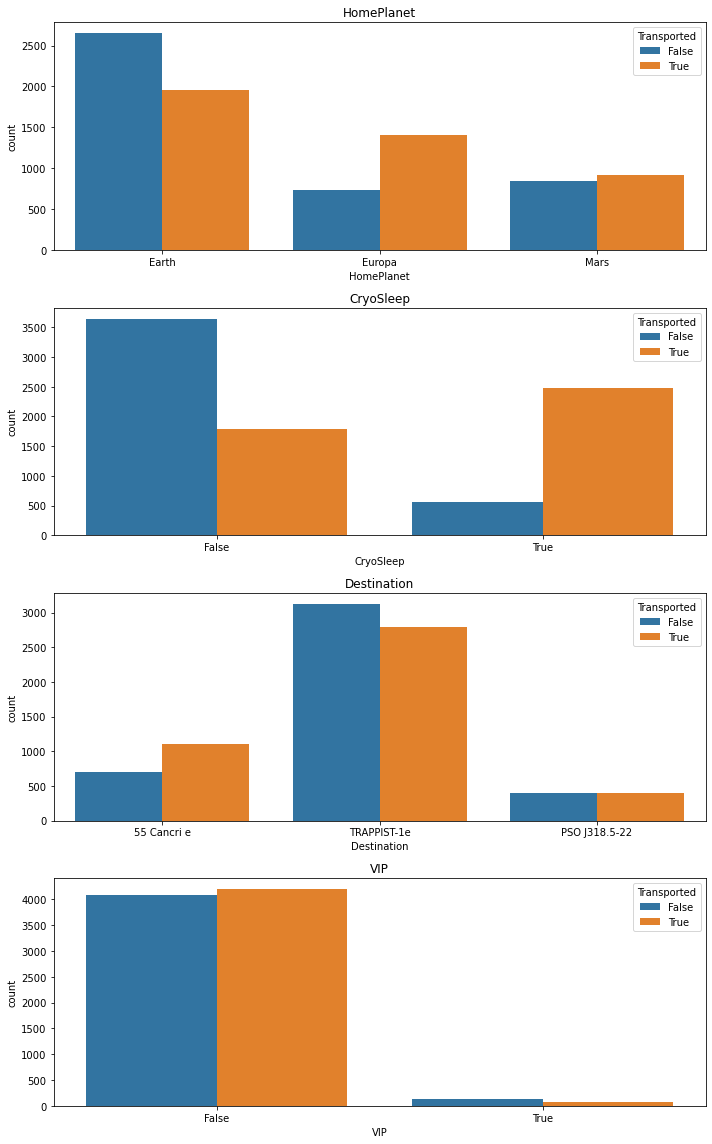

In [9]:
# Categorical features
cat_feats=['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

# Plot categorical features
fig=plt.figure(figsize=(10,16))
for i, var_name in enumerate(cat_feats):
    ax=fig.add_subplot(4,1,i+1)
    sns.countplot(data=data, x=var_name, axes=ax, hue='Transported')
    ax.set_title(var_name)
fig.tight_layout()
plt.show()

Passengers from Earth were less likely to be transported, passengers from Europa were more likely to be transported, and passengers from Mars were about equally likely to be transported or not transported.

Passengers who were in CryoSleep were more likely to be transported, and those were not in CryoSleep were less likely to be transported.

Passengers who were headed to 55 Cancri e were more likely to be transported, passengers headed to TRAPPIST-1e were less likely to be transported, and those headed to PSO J318.5-22 were about equally likely to be transported or not transported.

VIP status did not seem to influence whether a passenger was transported or not.

### Missing Values and Feature Engineering

In [10]:
data.isnull().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

#### PassengerId and Cabin

In [11]:
# Each 'PassengerId' takes the form gggg_pp where gggg indicates a group the passenger is travelling with and
# pp is their number within the group. People in a group are often family members, but not always.

# Create a new column with the group number
data["Group"] = data["PassengerId"].str[:-3].astype(int)

There are no missing passenger id's, so no group numbers are missing.

The 'Cabin' column takes the form deck/num/side, where side can be either P for Port or S for Starboard, so we can split it into three different columns.

In [12]:
data[["Deck", "Num", "Side"]] = data["Cabin"].str.split("/", expand=True)

#### Creating New Features for the Number of Passengers in the Same Group/Cabin

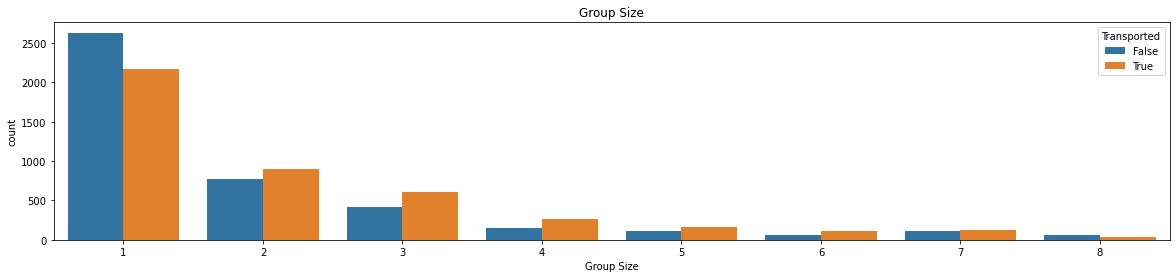

In [13]:
# Calculating number of passengers in each group and joining back with data to get a feature 'Group Size'
group_wise=data[['Group','PassengerId']].groupby(['Group']).count().rename(columns={"PassengerId":"Group Size"})
data=pd.merge(data,group_wise,how="left",left_on="Group",right_index=True)

# Distribution
plt.figure(figsize=(20,4))
sns.countplot(data=data, x='Group Size', hue='Transported')
plt.title('Group Size')
plt.show()

We can see there may be some relationship bewteen the number of passengers in a group and their survival rate. Both passengers in their own group and very large groups were less likely to be transported than not transported, and medium-sized groups were more likely to be transported than not transported.

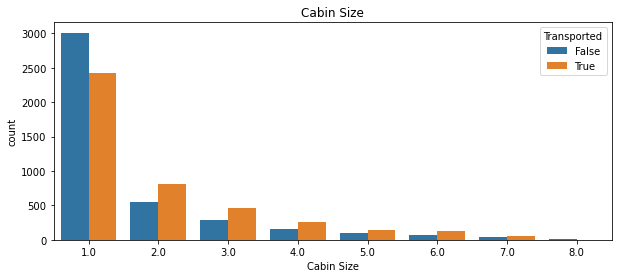

In [14]:
# Calculating number of passengers in each cabin and joining back with data to get a feature 'Cabin Size'
cabin_wise=data[['Cabin','PassengerId']].groupby(['Cabin']).count().rename(columns={"PassengerId":"Cabin Size"})
data=pd.merge(data,cabin_wise,how="left",left_on="Cabin",right_index=True)

# Distribution
plt.figure(figsize=(10,4))
sns.countplot(data=data, x='Cabin Size', hue='Transported')
plt.title('Cabin Size')
plt.show()

We see a similar trend for the number of passengers in the same cabin.

#### Name

In [15]:
# Create a new column for the last names of passengers
data['Last Name']=data['Name'].str.split().str[-1]

We can fill in missing last names by observing the last names in each group. This will help us fill in missing values in other columns later on.

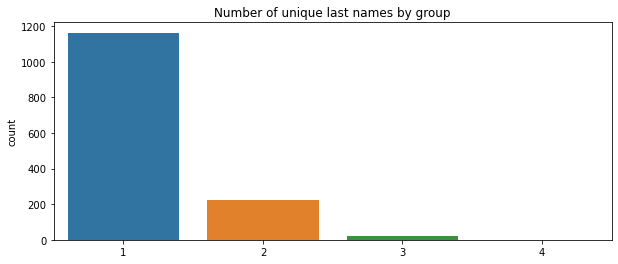

In [16]:
# Joint distribution of Group and Last Name
GLN_gb = data[data['Group Size']>1].groupby(['Group','Last Name'])['Last Name'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(10,4))
sns.countplot(x = (GLN_gb>0).sum(axis=1))
plt.title('Number of unique last names by group')
plt.show()

We can see that the vast majority of groups only have contain one family. Thus we can fill in missing last names using the most common last name in each group.

In [17]:
# Missing values before
LN_bef=data['Last Name'].isna().sum()

# Passengers with missing Last Name and in a group with known majority Last Name
GLN_index=data[data['Last Name'].isna()][(data[data['Last Name'].isna()]['Group']).isin(GLN_gb.index)].index

# Fill corresponding missing values
data.loc[GLN_index,'Last Name']=data.iloc[GLN_index,:]['Group'].map(lambda x: GLN_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Last Name missing values before:',LN_bef)
print('Last Name missing values after:',data['Last Name'].isna().sum())

Last Name missing values before: 200
Last Name missing values after: 104


The 'Last Name' column has many unique values and thus it is difficult to impute the remaining missing values using existing ones. Thus, we impute the missing last names with 'Unknown.'

In [18]:
data['Last Name'].nunique()

2217

In [19]:
# Impute missing values with 'Unknown', we won't use the 'Name' column anymore so we don't need to update it
data['Last Name'] = data['Last Name'].fillna('Unknown')

Assuming that passengers with the same last name are from the same family, we can observe how family size influences whether a passenger is transported or not. This will also be used later to fill in missing values for the 'HomePlanet' column.

In [20]:
# Create a new feature for family size
data['Family Size']=data['Last Name'].map(lambda x: data['Last Name'].value_counts()[x])

In [21]:
# Reset missing last names and family size for missing values to NaN
data.loc[data['Last Name'] == 'Unknown', 'Last Name'] = np.nan
data.loc[data['Family Size']>100,'Family Size'] = np.nan

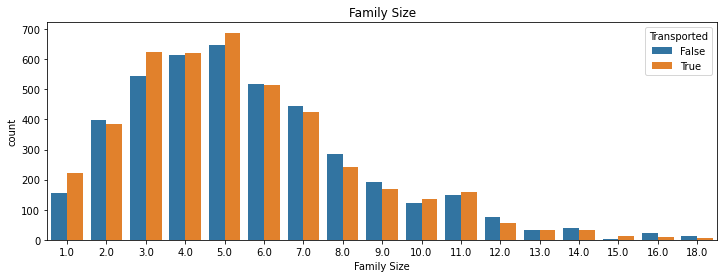

In [22]:
# Plot Family Size
plt.figure(figsize=(12,4))
sns.countplot(data=data, x='Family Size', hue='Transported')
plt.title('Family Size')
plt.show()

There appears to be a very slight trend of larger families having a lower chance of being transported, and smaller families having a higher chance of being transported.

#### Home Planet and Destination

In [23]:
data['HomePlanet'].value_counts()

Earth     4602
Europa    2131
Mars      1759
Name: HomePlanet, dtype: int64

In [24]:
data['Destination'].value_counts()

TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

Most of the values in the 'Destination' column are TRAPPIST-1e, so we impute the missing values with it.

In [25]:
data['Destination'] = data['Destination'].fillna("TRAPPIST-1e")

To fill in the missing home planets, we can look at how each passenger's home planet relates to their deck.

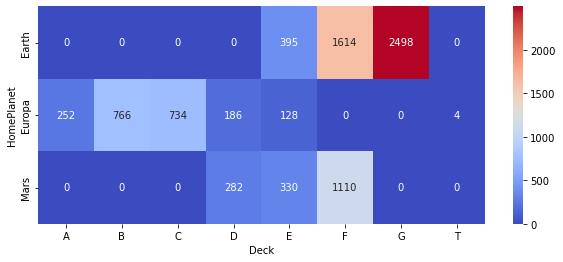

In [26]:
# Groupby of Deck and HomePlanet
DHP_gb = data.groupby(['Deck','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Heatmap of the groupby
plt.figure(figsize=(10,4))
sns.heatmap(DHP_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

We can see that all passengers in decks, A, B, C, or T came from Europa and all passengers from deck G came from Earth. Thus we can fill in the missing home planets of passengers on decks A, B, C, G, and T.

In [27]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Decks A, B, C or T came from Europa
data.loc[(data['HomePlanet'].isna()) & (data['Deck'].isin(['A', 'B', 'C', 'T'])), 'HomePlanet'] = 'Europa'

# Deck G came from Earth
data.loc[(data['HomePlanet'].isna()) & (data['Deck']=='G'), 'HomePlanet'] = 'Earth'

print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 201
HomePlanet missing values after: 109


Next, we can use the passengers' last names to show that passengers in the same family come from the same home planet.

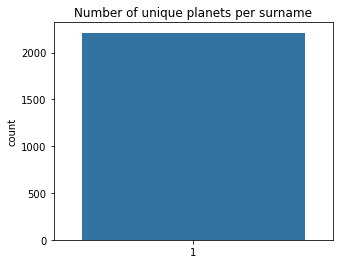

In [28]:
# Groupby of Last Name and HomePlanet
LNHP_gb=data.groupby(['Last Name','HomePlanet'])['HomePlanet'].size().unstack().fillna(0)

# Countplot of unique values
plt.figure(figsize=(5,4))
sns.countplot(x = (LNHP_gb>0).sum(axis=1))
plt.title('Number of unique planets per surname')
plt.show()

Therefore, we can fill in the missing home planets with the home planets of other passengers in the same family.

In [29]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Passengers with missing HomePlanet and in a family with known HomePlanet
LNHP_index=data[data['HomePlanet'].isna()][(data[data['HomePlanet'].isna()]['Last Name']).isin(LNHP_gb.index)].index

# Fill corresponding missing values
data.loc[LNHP_index,'HomePlanet']=data.iloc[LNHP_index,:]['Last Name'].map(lambda x: LNHP_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 109
HomePlanet missing values after: 8


Now we can look at the 8 remaining missing home planet values and the destination of those passengers, and look at the overall pattern of passengers' home planets and their destinations.

In [30]:
data[data['HomePlanet'].isna()][['PassengerId','HomePlanet','Destination', 'Deck']]

,PassengerId,HomePlanet,Destination,Deck
7,4840_01,NaN,TRAPPIST-1e,F
671,0242_01,NaN,TRAPPIST-1e,F
746,3331_01,NaN,TRAPPIST-1e,F
1199,2443_01,NaN,TRAPPIST-1e,D
2118,5989_01,NaN,TRAPPIST-1e,F
3162,6108_01,NaN,TRAPPIST-1e,F
4229,2817_01,NaN,TRAPPIST-1e,F
8629,5603_01,NaN,TRAPPIST-1e,E


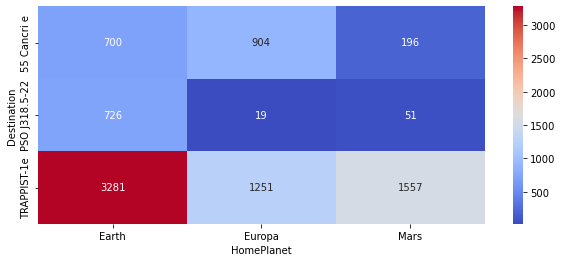

In [31]:
# Groupby of HomePlanet and Destination
HPD_gb=data.groupby(['HomePlanet','Destination'])['Destination'].size().unstack().fillna(0)

# Heatmap of the groupby
plt.figure(figsize=(10,4))
sns.heatmap(HPD_gb.T, annot=True, fmt='g', cmap='coolwarm')
plt.show()

All of the passengers are headed towards TRAPPIST-1e, and most passengers from Earth go there. However, we need to keep in mind that passengers on Deck D are not from Earth, and fill in those passengers' home planets with Mars instead.

In [32]:
# Missing values before
HP_bef=data['HomePlanet'].isna().sum()

# Fill remaining HomePlanet missing values with Earth (if not on deck D) or Mars (if on Deck D)
data.loc[(data['HomePlanet'].isna()) & ~(data['Deck']=='D'), 'HomePlanet']='Earth'
data.loc[(data['HomePlanet'].isna()) & (data['Deck']=='D'), 'HomePlanet']='Mars'

# Print number of missing values left
print('HomePlanet missing values before:',HP_bef)
print('HomePlanet missing values after:',data['HomePlanet'].isna().sum())

HomePlanet missing values before: 8
HomePlanet missing values after: 0


In [33]:
data.isnull().sum()

PassengerId       0
HomePlanet        0
CryoSleep       217
Cabin           199
Destination       0
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
Group             0
Deck            199
Num             199
Side            199
Group Size        0
Cabin Size      199
Last Name       104
Family Size     104
dtype: int64

#### Cabin

In [34]:
data['Deck'].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

In [35]:
data['Side'].value_counts()

S    4288
P    4206
Name: Side, dtype: int64

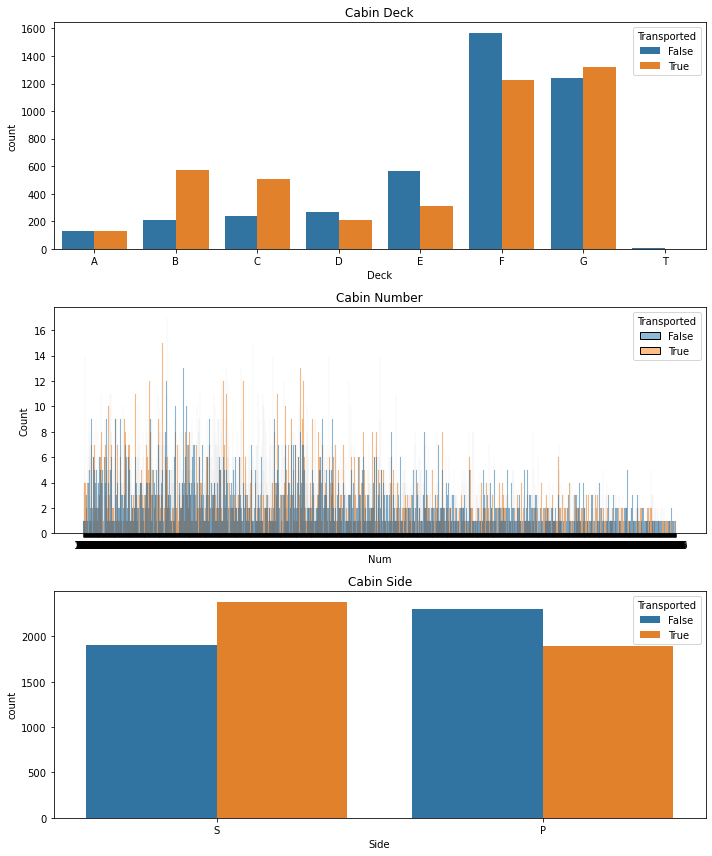

In [36]:
fig=plt.figure(figsize=(10,12))

# Deck distribution
plt.subplot(3,1,1)
sns.countplot(data=data, x='Deck', hue='Transported', order=['A','B','C','D','E','F','G','T'])
plt.title('Cabin Deck')

# Num distribution
plt.subplot(3,1,2)
sns.histplot(data=data, x='Num', hue='Transported',binwidth = 20)
plt.title('Cabin Number')

# Side distribution
plt.subplot(3,1,3)
sns.countplot(data=data, x='Side', hue='Transported')
plt.title('Cabin Side')
fig.tight_layout()

There appears to be some relationship between the cabin side/deck and whether that passenger was transported or not, but there doesn't appear to be much relationship between the cabin number and whether that passenger was transported or not.

Based on the value counts, there aren't any decks or sides where the vast majority of passengers stay, so we can't impute with the mode. However, we can observe that passengers in the same group are on the same cabin side.

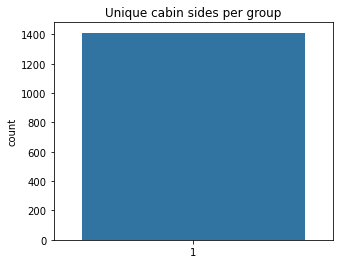

In [37]:
# Groupby of Group and Side
GS_gb=data[data['Group Size']>1].groupby(['Group','Side'])['Side'].size().unstack().fillna(0)

plt.figure(figsize=(5,4))
sns.countplot(x = (GS_gb>0).sum(axis=1))
plt.title('Unique cabin sides per group')
fig.tight_layout()

In [38]:
# Missing values before
S_bef=data['Side'].isna().sum()

# Passengers with missing cabin side and in a group with known cabin side
GS_index=data[data['Side'].isna()][(data[data['Side'].isna()]['Group']).isin(GS_gb.index)].index

# Fill corresponding missing values
data.loc[GS_index,'Side']=data.iloc[GS_index,:]['Group'].map(lambda x: GS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Side missing values before:',S_bef)
print('Side missing values after:',data['Side'].isna().sum())

Side missing values before: 199
Side missing values after: 99


To fill in the rest of the missing values, we can observe that most passengers in the same family have the same cabin side.

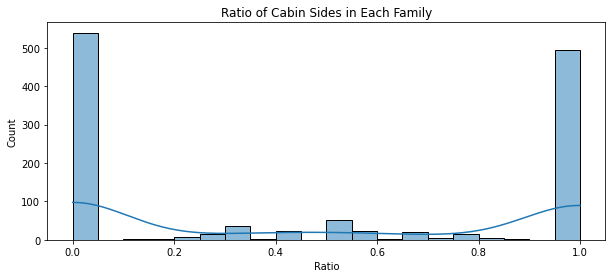

In [39]:
# Groupby of Last Name and Cabin side
LNS_gb=data[data['Group Size']>1].groupby(['Last Name','Side'])['Side'].size().unstack().fillna(0)

# Ratio of sides
LNS_gb['Ratio']=LNS_gb['P']/(LNS_gb['P']+LNS_gb['S'])

# Histogram of ratio
plt.figure(figsize=(10,4))
sns.histplot(LNS_gb['Ratio'], kde=True, binwidth=0.05)
plt.title('Ratio of Cabin Sides in Each Family')
plt.show()

In [40]:
print('Percentage of families all on the same cabin side:', 100*np.round((LNS_gb['Ratio'].isin([0,1])).sum()/len(LNS_gb),3),'%')

Percentage of families all on the same cabin side: 83.6 %


We can use this knowledge to replace the missing cabin side values of passengers in the same family.

In [41]:
# Missing values before
S_bef=data['Side'].isna().sum()

# Passengers with missing cabin side and in a family with known cabin side
LNS_index=data[data['Side'].isna()][(data[data['Side'].isna()]['Last Name']).isin(LNS_gb.index)].index

# Fill corresponding missing values
data.loc[LNS_index,'Side']=data.iloc[LNS_index,:]['Last Name'].map(lambda x: LNS_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Side missing values before:',S_bef)
print('Side missing values after:',data['Side'].isna().sum())

Side missing values before: 99
Side missing values after: 52


The cabin side values are still very evenly split, so we will fill in the remaining values with 'No_Side.'

In [42]:
data['Side'].value_counts()

S    4369
P    4272
Name: Side, dtype: int64

In [43]:
data['Side'] = data['Side'].fillna("Z No_Side") # Z to maintain order

To fill in the missing cabin deck values, we can observe that most groups have the same cabin deck. 

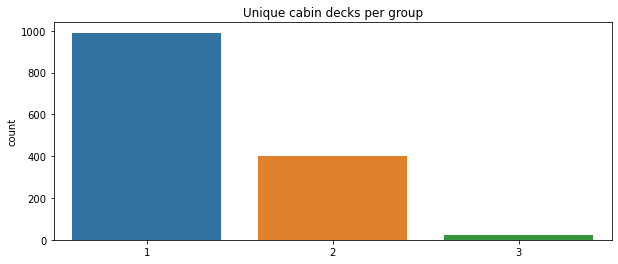

In [44]:
# Joint distribution of Group and Cabin features
GD_gb=data[data['Group Size']>1].groupby(['Group','Deck'])['Deck'].size().unstack().fillna(0)

# Countplots
plt.figure(figsize=(10,4))
sns.countplot(x = (GD_gb>0).sum(axis=1))
plt.title('Unique cabin decks per group')
plt.show()

In [45]:
# Missing values before
D_bef=data['Deck'].isna().sum()

# Passengers with missing Cabin deck and in a group with known majority Cabin deck
D_index=data[data['Deck'].isna()][(data[data['Deck'].isna()]['Group']).isin(GD_gb.index)].index

# Fill corresponding missing values
data.loc[D_index,'Deck']=data.iloc[D_index,:]['Group'].map(lambda x: GD_gb.idxmax(axis=1)[x])

# Print number of missing values left
print('Deck missing values before:',D_bef)
print('Deck missing values after:',data['Deck'].isna().sum())

Deck missing values before: 199
Deck missing values after: 99


Next, we can observe how each passenger's home planet and destination relate to their deck.

In [46]:
# Joint distribution
data.groupby(['HomePlanet', 'Destination', 'Deck'])['Deck'].size().unstack().fillna(0)

Deck                          A      B      C      D      E       F       G  \
HomePlanet Destination                                                        
Earth      55 Cancri e      0.0    0.0    0.0    0.0   47.0   273.0   372.0   
           PSO J318.5-22    0.0    0.0    0.0    0.0   29.0   222.0   463.0   
           TRAPPIST-1e      0.0    0.0    0.0    0.0  331.0  1166.0  1753.0   
Europa     55 Cancri e    113.0  343.0  322.0   67.0   49.0     0.0     0.0   
           PSO J318.5-22    2.0    3.0   14.0    0.0    0.0     0.0     0.0   
           TRAPPIST-1e    147.0  450.0  425.0  128.0   85.0     0.0     0.0   
Mars       55 Cancri e      0.0    0.0    0.0   48.0   21.0   126.0     0.0   
           PSO J318.5-22    0.0    0.0    0.0   17.0   13.0    20.0     0.0   
           TRAPPIST-1e      0.0    0.0    0.0  227.0  310.0  1003.0     0.0   

Deck                        T  
HomePlanet Destination         
Earth      55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    0.0  
Europa     55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    5.0  
Mars       55 Cancri e    0.0  
           PSO J318.5-22  0.0  
           TRAPPIST-1e    0.0

We can see that most passengers from Earth are most likely to be on Decks F or G, most passengers from Mars are on Deck F, and most passengers from Europa are on Decks B or C. We will impute the missing deck values with the mode of each subgroup.

In [47]:
data.groupby(['HomePlanet', 'Destination'])['Deck'].agg(pd.Series.mode)

HomePlanet  Destination  
Earth       55 Cancri e      G
            PSO J318.5-22    G
            TRAPPIST-1e      G
Europa      55 Cancri e      B
            PSO J318.5-22    C
            TRAPPIST-1e      B
Mars        55 Cancri e      F
            PSO J318.5-22    F
            TRAPPIST-1e      F
Name: Deck, dtype: object

We can see that the mode for all passengers from Earth is deck G, and the mode for all passengers from Mars is deck F. Lastly, the modes for Europa are B or C depending on the destination of the passenger.

In [48]:
# Missing values before
D_bef=data['Deck'].isna().sum()

# Mode for passengers from Earth is deck G
data.loc[(data['Deck'].isna()) & (data['HomePlanet'] == 'Earth'), 'Deck'] = 'G'

# Mode for passengers from Mars is deck F
data.loc[(data['Deck'].isna()) & (data['HomePlanet'] == 'Mars'), 'Deck'] = 'F'

# Mode for passengers from Europa is deck B or C depending on destination
data.loc[(data['Deck'].isna()) & (data['HomePlanet'] == 'Europa') & ~(data['Destination'] == 'PSO J318.5-22'), 'Deck'] = 'B'
data.loc[(data['Deck'].isna()) & (data['HomePlanet'] == 'Europa') & (data['Destination'] == 'PSO J318.5-22'), 'Deck'] = 'C'

# Print number of missing values left
print('Deck missing values before:',D_bef)
print('Deck missing values after:',data['Deck'].isna().sum())

Deck missing values before: 99
Deck missing values after: 0


#### CryoSleep and VIP

CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

VIP - Whether the passenger has paid for special VIP service during the voyage.

In [49]:
data['VIP'].value_counts()

False    8291
True      199
Name: VIP, dtype: int64

The vast majority of people are not VIPs, so we assume every passenger with a missing VIP value is not a VIP.

In [50]:
data['VIP'] = data['VIP'].fillna(False)

In [51]:
data['CryoSleep'].value_counts()

False    5439
True     3037
Name: CryoSleep, dtype: int64

Most of the rows with missing values for the expenditure features are only missing 1 value, so calculating the total expenditure won't cause large issues (rows with mostly missing values could've been added to equal 0).

In [52]:
# Create a new feature for the total expenditure of each passenger
exp_features=['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Note that this counts NaN values as 0
data["Expenditure"]=data[exp_features].sum(axis="columns")

From below, we know that passengers in CryoSleep do not spend any money.

In [53]:
data.loc[data['CryoSleep'] == True]['Expenditure'].value_counts()

0.0    3037
Name: Expenditure, dtype: int64

In [54]:
# Replace all expenditure features with 0 if CryoSleep is True
for col in exp_features:
    data.loc[(data[col].isnull()) & (data['CryoSleep']==True), col] = 0

From below, we also know that if a passenger spent money, they are not in CryoSleep.

In [55]:
data[data['Expenditure'] > 0]['CryoSleep'].value_counts()

False    4921
Name: CryoSleep, dtype: int64

In [56]:
# If the passenger spent any money, they are not in CryoSleep
data.loc[(data['CryoSleep'].isnull()) & (data['Expenditure'] > 0), 'CryoSleep'] = False

From below, we also know that most of the passengers who did not spend money are in CryoSleep.

In [57]:
data.loc[data['Expenditure'] == 0]['CryoSleep'].value_counts()

True     3037
False     518
Name: CryoSleep, dtype: int64

In [58]:
# If the passenger did not spend any money, they are in CryoSleep
data.loc[(data['CryoSleep'].isnull()) & (data['Expenditure'] == 0), 'CryoSleep'] = True

#### Convert Categorical Features to Numerical Features

In [59]:
# Convert boolean features to numerical features
data[['CryoSleep', 'VIP', 'Transported']] = data[['CryoSleep', 'VIP', 'Transported']].astype(int)

In [60]:
data[['HomePlanet', 'Destination', 'Side', 'Deck']].nunique(axis = 0)

HomePlanet     3
Destination    3
Side           3
Deck           8
dtype: int64

In [61]:
# There are only a few unique values for these columns
# Use one-hot encoding to transform the categorical data into numerical data
data = pd.concat([data, pd.get_dummies(data['HomePlanet']), pd.get_dummies(data['Destination']), pd.get_dummies(data['Side'])], axis = 'columns')

Since the 'Deck' column takes on several different values, using one-hot encoding would waste memory. We use label encoding instead.

In [62]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
data['Deck'] = encoder.fit_transform(data['Deck'])

In [63]:
# Drop these columns since they are no longer needed
data.drop(columns=['HomePlanet', 'Destination', "Cabin", 'Side'],inplace=True)

#### Imputing Missing Values using KNNImputer

In [64]:
from sklearn.impute import KNNImputer

KNNImputer - Each sample’s missing values are imputed using the mean value from n_neighbors nearest neighbors found in the training set. Two samples are close if the features that neither is missing are close.

In [65]:
data.isnull().sum()

PassengerId        0
CryoSleep          0
Age              179
VIP                0
RoomService      113
FoodCourt        113
ShoppingMall     112
Spa              118
VRDeck           126
Name             200
Transported        0
Group              0
Deck               0
Num              199
Group Size         0
Cabin Size       199
Last Name        104
Family Size      104
Expenditure        0
Earth              0
Europa             0
Mars               0
55 Cancri e        0
PSO J318.5-22      0
TRAPPIST-1e        0
P                  0
S                  0
Z No_Side          0
dtype: int64

In [66]:
# Columns used to help impute missing values (numerical features, we use the same ones to train models)
cols = ['CryoSleep', 'Age', 'VIP', 
        'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure',
        'Group', 'Group Size', 'Cabin Size', 'Family Size', 'Deck', 'Num', 
        'Earth', 'Europa', 'Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 
        'P', 'S', 'Z No_Side']

# Use KNNImputer to impute the missing features
imputer=KNNImputer(n_neighbors=5)
data[cols] = imputer.fit_transform(data[cols])

In [67]:
data.isnull().sum()

PassengerId        0
CryoSleep          0
Age                0
VIP                0
RoomService        0
FoodCourt          0
ShoppingMall       0
Spa                0
VRDeck             0
Name             200
Transported        0
Group              0
Deck               0
Num                0
Group Size         0
Cabin Size         0
Last Name        104
Family Size        0
Expenditure        0
Earth              0
Europa             0
Mars               0
55 Cancri e        0
PSO J318.5-22      0
TRAPPIST-1e        0
P                  0
S                  0
Z No_Side          0
dtype: int64

In [68]:
# Update Expenditure column since the initial calculation summed over missing values
data["Expenditure"]=data[exp_features].sum(axis="columns")

In [69]:
# Add 'Transported' column back to the end (just for organization)
data['Transported'] = data.pop('Transported')
data.head()

,PassengerId,CryoSleep,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,...,Earth,Europa,Mars,55 Cancri e,PSO J318.5-22,TRAPPIST-1e,P,S,Z No_Side,Transported
0,3856_01,0.0,23.0,0.0,339.0,754.0,7.0,0.0,0.0,Ward Alvasquez,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1
1,6110_01,0.0,57.0,0.0,0.0,0.0,0.0,0.0,642.0,Sus Warrishales,...,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1
2,6908_01,0.0,60.0,0.0,0.0,960.0,46.0,854.0,17074.0,Sheleon Swinvul,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0
3,5628_01,1.0,27.0,0.0,0.0,0.0,0.0,0.0,0.0,Ebonya Potthews,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0
4,1193_02,1.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,Solam Presstic,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1


In [70]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 28 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    8693 non-null   object 
 1   CryoSleep      8693 non-null   float64
 2   Age            8693 non-null   float64
 3   VIP            8693 non-null   float64
 4   RoomService    8693 non-null   float64
 5   FoodCourt      8693 non-null   float64
 6   ShoppingMall   8693 non-null   float64
 7   Spa            8693 non-null   float64
 8   VRDeck         8693 non-null   float64
 9   Name           8493 non-null   object 
 10  Group          8693 non-null   float64
 11  Deck           8693 non-null   float64
 12  Num            8693 non-null   float64
 13  Group Size     8693 non-null   float64
 14  Cabin Size     8693 non-null   float64
 15  Last Name      8589 non-null   object 
 16  Family Size    8693 non-null   float64
 17  Expenditure    8693 non-null   float64
 18  Earth   

In [71]:
# Set the train, valid, and test dataframes to their respective preprocessed data for training
train = data[data['PassengerId'].isin(train['PassengerId'])]
valid = data[data['PassengerId'].isin(valid['PassengerId'])]
test = data[data['PassengerId'].isin(test['PassengerId'])]

## Modeling

In [72]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV # For hyperparameter tuning
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, precision_score, recall_score, f1_score

In [73]:
data.columns

Index(['PassengerId', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt',
       'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Group', 'Deck', 'Num',
       'Group Size', 'Cabin Size', 'Last Name', 'Family Size', 'Expenditure',
       'Earth', 'Europa', 'Mars', '55 Cancri e', 'PSO J318.5-22',
       'TRAPPIST-1e', 'P', 'S', 'Z No_Side', 'Transported'],
      dtype='object')

In [74]:
# Columns to train on 
cols = ['CryoSleep', 'Age', 'VIP', 
        'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Expenditure',
        'Group', 'Group Size', 'Cabin Size', 'Family Size', 'Deck', 'Num', 
        'Earth', 'Europa', 'Mars', '55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e', 
        'P', 'S', 'Z No_Side']

### Logistic Regression and Support Vector Machine (Non-linear) (Sumanth)

### Linear Discriminant Analysis (Thresha)

In [75]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [76]:
lr = LogisticRegression(max_iter = 10000)
svm = SVC()
lda = LinearDiscriminantAnalysis()

models = [lr,
          svm,
          lda
]

model_names = [
    'Logistic Regression',
    'Support Vector Machine',
    'Linear Discriminant Analysis',
    'Quadratic Discriminant Analysis',
]

In [77]:
for name, model in zip(model_names, models):
    model.fit(train[cols].values, train['Transported'])
    y_pred = model.predict(test[cols].values)
    cm = confusion_matrix(test['Transported'], y_pred)
    accuracy = accuracy_score(test['Transported'], y_pred)
    precision = precision_score(test['Transported'], y_pred)
    recall = recall_score(test['Transported'], y_pred)
    f1 = f1_score(test['Transported'], y_pred)

    print(f"{name}:")
    print("Confusion Matrix:")
    print(cm)
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}\n")

Logistic Regression:
Confusion Matrix:
[[687 181]
 [166 705]]
Accuracy: 0.8004600345025877
Precision: 0.7957
Recall: 0.8094
F1 Score: 0.8025

Support Vector Machine:
Confusion Matrix:
[[610 258]
 [100 771]]
Accuracy: 0.7941345600920069
Precision: 0.7493
Recall: 0.8852
F1 Score: 0.8116

Linear Discriminant Analysis:
Confusion Matrix:
[[735 133]
 [245 626]]
Accuracy: 0.7826336975273146
Precision: 0.8248
Recall: 0.7187
F1 Score: 0.7681



### Random Forest (Thresha)

In [78]:
from sklearn.ensemble import RandomForestClassifier

In [79]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for the Random Forest model
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a Random Forest model
rf_clf = RandomForestClassifier(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit the GridSearchCV object to the data
grid_search.fit(train[cols].values, train['Transported'])

Fitting 5 folds for each of 288 candidates, totalling 1440 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [None, 10, 20, 30],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [10, 50, 100, 200]},
             verbose=2)

In [80]:
# Get the best parameters from the GridSearchCV
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the Random Forest model using the best parameters
best_rf_clf = RandomForestClassifier(**best_params, random_state=42)
best_rf_clf.fit(train[cols].values, train['Transported'])

# Make predictions on the test set
y_pred = best_rf_clf.predict(test[cols].values)

# Evaluate the model
print("Accuracy:", accuracy_score(test['Transported'], y_pred))
print("\nClassification Report:\n", classification_report(test['Transported'], y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(test['Transported'], y_pred))

Best Parameters: {'bootstrap': True, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}
Accuracy: 0.8125359401955147

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82       868
           1       0.82      0.80      0.81       871

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739


Confusion Matrix:
 [[719 149]
 [177 694]]


In [81]:
feature_importances = best_rf_clf.feature_importances_

# Sort the feature importances in descending order.
sorted_feature_importances = np.argsort(feature_importances)[::-1]

# Print the top 10 features.
for i in range(10):
    print(f"Feature {sorted_feature_importances[i]}: {feature_importances[sorted_feature_importances[i]]}")

Feature 8: 0.1390408787881147
Feature 6: 0.08901962885236402
Feature 3: 0.08168135732709168
Feature 0: 0.07946262314242417
Feature 7: 0.07849537113015367
Feature 4: 0.07618290199340956
Feature 5: 0.07078807041989606
Feature 14: 0.06777239185115914
Feature 9: 0.06452761812785283
Feature 1: 0.052385940901662285


### K-Nearest Neighbors (Andrew)

In [82]:
from sklearn.neighbors import KNeighborsClassifier

In [83]:
# The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) 
# in terms of both training time and validation score.
knn = KNeighborsClassifier()

# Use GridSearchCV to tune hyperparameters
param_grid = {
    'n_neighbors': np.arange(5, 40),
}

grid_search_knn = GridSearchCV(knn, param_grid, scoring='accuracy', n_jobs=-1)

In [84]:
grid_search_knn.fit(train[cols].values, train['Transported'])

GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': array([ 5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39])},
             scoring='accuracy')

In [85]:
grid_search_knn.best_params_

{'n_neighbors': 27}

In [86]:
grid_search_knn.best_score_

0.776765680107671

In [87]:
knn_best = grid_search_knn.best_estimator_
knn_best.fit(train[cols].values, train['Transported'])

KNeighborsClassifier(n_neighbors=27)

In [88]:
# Validation set accuracy
accuracy_score(valid['Transported'], knn_best.predict(valid[cols].values))

0.7974137931034483

In [89]:
# Test set accuracy
accuracy_score(test['Transported'], knn_best.predict(test[cols].values))

0.7912593444508338

### Neural Network (Andrew)

In [90]:
from sklearn.neural_network import MLPClassifier

In [91]:
# The default solver ‘adam’ works pretty well on relatively large datasets (with thousands of training samples or more) 
# in terms of both training time and validation score.
nn = MLPClassifier(solver = 'adam', activation = 'logistic', early_stopping = True)

# Use GridSearchCV to tune hyperparameters
param_grid = {
'hidden_layer_sizes': [(100,), (100, 100), (200,), (200, 200), (300,), (300, 300)],
'alpha': 10.0 ** -np.arange(1, 7)
}

grid_search_nn = GridSearchCV(nn, param_grid, scoring='accuracy', n_jobs=-1)

In [92]:
grid_search_nn.fit(train[cols].values, train['Transported'])

GridSearchCV(estimator=MLPClassifier(activation='logistic',
                                     early_stopping=True),
             n_jobs=-1,
             param_grid={'alpha': array([1.e-01, 1.e-02, 1.e-03, 1.e-04, 1.e-05, 1.e-06]),
                         'hidden_layer_sizes': [(100,), (100, 100), (200,),
                                                (200, 200), (300,),
                                                (300, 300)]},
             scoring='accuracy')

In [93]:
grid_search_nn.best_params_

{'alpha': 0.001, 'hidden_layer_sizes': (200,)}

In [94]:
grid_search_nn.best_score_

0.7901897012741245

In [116]:
nn_best = grid_search_nn.best_estimator_
nn_best.fit(train[cols].values, train['Transported'])

MLPClassifier(activation='logistic', alpha=0.001, early_stopping=True,
              hidden_layer_sizes=(200,))

In [117]:
# Validation set accuracy
accuracy_score(valid['Transported'], nn_best.predict(valid[cols].values))

0.7974137931034483

In [118]:
# Test set accuracy
accuracy_score(test['Transported'], nn_best.predict(test[cols].values))

0.80448533640023

## Stacking Method (Andrew)

In [119]:
from sklearn.ensemble import StackingClassifier
from catboost import CatBoostClassifier # For final estimator

In [120]:
lg = LogisticRegression()

In [121]:
# CatBoost is an algorithm for gradient boosting on decision trees
# It was the best model that I tested for the Kaggle competition, and we already used logistic regression (the default) as one of our models
cat = CatBoostClassifier(verbose=0)

In [123]:
estimators = [
    ('Logistic Regression', lr),
    ('SVM', svm),
    ('Linear Discriminant Analysis', lda),
    ('K-Nearest Neighbors', knn_best),
    ('Neural Network', nn_best),
    ('Random Forest', best_rf_clf)
]

sclf = StackingClassifier(estimators = estimators, final_estimator = cat, cv=5)

In [142]:
sclf.fit(train[cols].values, train['Transported'])

StackingClassifier(cv=5,
                   estimators=[('Logistic Regression',
                                LogisticRegression(max_iter=10000)),
                               ('SVM', SVC()),
                               ('Linear Discriminant Analysis',
                                LinearDiscriminantAnalysis()),
                               ('K-Nearest Neighbors',
                                KNeighborsClassifier(n_neighbors=27)),
                               ('Neural Network',
                                MLPClassifier(activation='logistic',
                                              alpha=0.001, early_stopping=True,
                                              hidden_layer_sizes=(200,))),
                               ('Random Forest',
                                RandomForestClassifier(max_depth=20,
                                                       min_samples_leaf=2,
                                                       min_samples_split=10,
       

In [143]:
# Validation set accuracy
accuracy_score(valid['Transported'], sclf.predict(valid[cols].values))

0.8117816091954023

In [144]:
# Test set accuracy
accuracy_score(test['Transported'], sclf.predict(test[cols].values))

0.8085106382978723